# Varying Noise Experiment
In this notebook, we test our algorithm in setting where there is a lot of noise variance. We then compare our results to other methods on the same task.

In [1]:
# #@title Run this to setup libraries and mount drive
# %load_ext autoreload
# # swig required for building wheel for orthnet package
# !apt-get install swig
# !pip3 install orthnet 
# !pip install GPUtil
# !pip3 install cox
# !pip install tensorboardX
# !pip install delphi.ai --no-cache-dir

# # mount google drive locally onto colab
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

import sys 

sys.path.append('/Users/patroklos/Desktop/delphi_')


import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA

from torch.distributions import Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.store import Store
from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 
import IPython 

from delphi.stats.truncated_linear_regression import TruncatedLinearRegression
from delphi import oracle
from delphi.utils.helpers import Parameters

# commands and arguments
COMMAND = 'Rscript'
PATH2SCRIPT = './truncreg.R'
TMP_FILE = 'tmp.csv'
RESULT_FILE = 'result.csv'

# mean squared error loss
mse_loss = ch.nn.MSELoss(reduction='mean')

In [146]:
args = Parameters({
    "samples": 5000, # number of samples to generate for ground-truth
    "c": 0, # left truncation parameter
    "trials": 20,
    "x_lower": -10,  # lower bound for generating input features
    "x_upper": 10,  # upper bound for generating input features
    "lower": -1, # lower bound for generating ground-truth
    "upper": 1, # lower bound for generating ground-truth
    'var': 10,  # maximum variance to use in procedure 
    'fit_intercept': True, 
    'exp': 'revival', 
    'out_dir': 'drive/MyDrive/Results/trunc_reg/',
})

I will first begin, by showing how to use our algorithm in a 1 dimensional setting. I will sample input features from a Uniform distribution, I will also sample my ground-truth from a Uniform distribution, and I will add Gaussian noise with noise variance 10.

In [147]:
# distribution for generating feature vectors
d, k = 10, 1
W = Uniform(args.lower, args.upper)
M = Uniform(args.x_lower, args.x_upper)
phi = oracle.Left_Regression(Tensor([args.C]))
# phi = oracle.Identity()

# generate ground truth
gt = ch.nn.Linear(in_features=d, out_features=k)
gt.weight = ch.nn.Parameter(W.sample(ch.Size([k, d])))

# gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
gt.bias = ch.nn.Parameter(W.sample(ch.Size([1, 1]))) if args.fit_intercept else None

weight, intercept = gt.weight, gt.bias
print(f"gt weight: {weight}")
if args.fit_intercept:
    print(f"gt intercept: {intercept}")

# create base classifier
with ch.no_grad():
    # generate data
    X = M.sample(ch.Size([args.samples, d])) if isinstance(M, Uniform) else M.sample(ch.Size([args.samples]))
    y = gt(X)

noise_var = Tensor([1.0])[...,None]
# remove synthetic data from the computation graph
with ch.no_grad():
    # add noise to ground-truth pedictions
    noised = y + ch.sqrt(noise_var) * ch.randn(X.size(0), 1)
    # truncate based off of the standardized data
    indices = phi(noised).nonzero()[:,0]
    y_trunc, x_trunc = noised[indices], X[indices]
    print('y trunc size: {}'.format(y_trunc.size()))
    print('x truncc size: {}'.format(x_trunc.size()))
    alpha = y_trunc.size(0) / y.size(0)
    print(f"alpha: {alpha}")

# normalize input features
x_trunc_mu = x_trunc.mean(0)
x_trunc_centered = x_trunc - x_trunc_mu
l_inf = LA.norm(x_trunc_centered, dim=-1, ord=float('inf')).max()
beta = l_inf * (X.size(1) ** .5)
x_trunc_norm_centered = x_trunc_centered / beta
X_norm_centered = (X - x_trunc_mu) / beta

y_trunc_mu = y_trunc.mean(0)
y_trunc_centered = y_trunc - y_trunc_mu
noised_centered = noised - y_trunc_mu
    
# ground-truth OLS
gt_ols = LinearRegression(fit_intercept=args.fit_intercept)
gt_ols.fit(X_norm_centered, noised_centered)
if args.fit_intercept:
    gt_ = ch.from_numpy(np.concatenate([gt_ols.coef_.flatten(), gt_ols.intercept_]))
    print("gt ols coef: ", gt_ols.coef_)
    print("gt ols intercept: ", gt_ols.intercept_)
else: 
    gt_ = gt_ols.coef_.flatten()
    print("gt ols coef: ", gt_ols.coef_)

trunc_ols = LinearRegression(fit_intercept=args.fit_intercept)
trunc_ols.fit(x_trunc_norm_centered, y_trunc_centered)
trunc_ols_pred = trunc_ols.predict(x_trunc_norm_centered)
print("trunc ols coef: ", trunc_ols.coef_)
if args.fit_intercept:
    print("trunc ols intercept: ", trunc_ols.intercept_)

if X.size(1) == 1:
    # data for plotting regressions
    data = np.linspace(X_norm_centered.min(), X_norm_centered.max(), 100).reshape(100, 1)

    ax = plt.subplot(1, 1, 1)
    plt.scatter(X_norm_centered, noised_centered)
    plt.scatter(x_trunc_norm_centered, y_trunc_centered)
    plt.plot(data, gt_ols.predict(data), color='green', label='gt ols')
    plt.plot(data, trunc_ols.predict(data), color='red', label='trunc ols')
    plt.legend()
    plt.title("Empirical and Ground Truth Dataset and Model")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    
emp_noise_var = (y_trunc - trunc_ols_pred).var(0)
print("emp noise var: ", emp_noise_var)

gt weight: Parameter containing:
tensor([[-0.1465,  0.2593, -0.7988, -0.6592, -0.9728,  0.7571,  0.7031,  0.1806,
         -0.8125,  0.8270]], requires_grad=True)
gt intercept: Parameter containing:
tensor([[0.9286]], requires_grad=True)
y trunc size: torch.Size([2658, 1])
x truncc size: torch.Size([2658, 10])
alpha: 0.5316
gt ols coef:  [[ -5.565523    9.803856  -30.101515  -25.001205  -36.729042   28.435383
   26.456596    6.9692683 -30.514868   31.182955 ]]
gt ols intercept:  [-0.06029701]
trunc ols coef:  [[ -5.4569325   9.699234  -29.897488  -24.77415   -36.165806   28.238518
   26.112127    6.963383  -30.029976   30.887775 ]]
trunc ols intercept:  [-3.772859e-07]
emp noise var:  tensor([0.9730])


# Check Truncated Gradients
Here, I check my gradients with an identity oracle. To show the correctness of my custom gradients. 

In [7]:
from delphi.grad import TruncatedMSE, TruncatedUnknownVarianceMSE

weight = ch.cat([gt.weight, gt.bias], axis=1).T
# weight.requires_grad = True
features = ch.cat([X_norm, ch.ones(X_norm.size(0), 1)], axis=1)

pred = features@weight
loss = mse_loss(pred, y)
mse_grad = ch.autograd.grad(loss, weight)[0].flatten()
print('MSE grad: {}'.format(mse_grad))

pred = features@weight
# trunc_loss = TruncatedMSE.apply(pred, y, oracle.Identity(), noise_var, 1000)
trunc_loss = TruncatedMSE.apply(pred, y, phi, noise_var, 10000)
# print(f'trunc loss: {trunc_loss}')
trunc_mse_grad = ch.autograd.grad(trunc_loss, weight)[0].flatten()
print('Trunc MSE grad: {}'.format(trunc_mse_grad))


pred = features@weight
lambda_ = ch.nn.Parameter(ch.Tensor([[emp_noise_var]])).inverse()
# trunc_unknown_loss = TruncatedUnknownVarianceMSE.apply(pred, y, lambda_, oracle.Identity(), 1000)
trunc_unknown_loss = TruncatedUnknownVarianceMSE.apply(pred, y, lambda_, phi, 10000)
# print(f'trunc unknown loss: {trunc_unknown_loss}')
trunc_unknown_mse_grad = ch.autograd.grad(trunc_unknown_loss, weight)[0].flatten()
print('Trunc Unknown Variance MSE grad: {}'.format(trunc_unknown_mse_grad))

pred = features@weight
lambda_ = ch.nn.Parameter(ch.Tensor([[emp_noise_var]])).inverse()
trunc_unknown_loss = TruncatedUnknownVarianceMSE.apply(pred, y, lambda_, phi, 10000)
trunc_unknown_lambda_grad = ch.autograd.grad(trunc_unknown_loss, lambda_)[0].flatten()
print('Trunc Unknown Variance Lambda grad: {}'.format(trunc_unknown_lambda_grad))

MSE grad: tensor([-0.8781,  0.4699, -1.1361, -2.7447, -2.6426, -0.4210])
Trunc MSE grad: tensor([-0.4687,  0.2358, -0.6025, -1.3995, -1.3486,  1.8406])
Trunc Unknown Variance MSE grad: tensor([-0.0993,  0.0500, -0.1275, -0.2964, -0.2856,  0.3791])
Trunc Unknown Variance Lambda grad: tensor([31.9588])


We will now run our procedure for truncated regression with known variance, assuming that the empirical noise variance is the actual noise variance. Since we applied feature transformations to our truncated dataset, we now need to reverse the trnasformations after the completion of our procedure.

In [68]:
train_kwargs = Parameters({
    'phi': phi, 
    'alpha': alpha, 
    'noise_var': float(emp_noise_var), 
    'epochs': 10,
#     'momentum': .25,
    'verbose': True,
    'trials': 1,
})
known_emp_trunc_reg = TruncatedLinearRegression(train_kwargs)
known_emp_trunc_reg.fit(x_trunc_norm, y_trunc)

Train Epoch:8 | Loss -0.7552 | Prec1: 0.000 | Prec5: 0.000 | Reg term: 0.0 ||:   0%|          | 0/8 [00:00<?, ?it/s]

trial: 1


In [69]:
if X.size(1) == 1:
    ax = plt.subplot(1, 1, 1)
    plt.plot(data, trunc_ols.predict(data), color='red', label='ols')

    plt.plot(data, known_emp_trunc_reg.predict(Tensor(data)).detach().numpy(), label='known', color='blue')
    plt.plot(data, gt_ols.predict(data), color='green', label='gt')
    plt.scatter(X_norm, noised, label='entire dataset')
    plt.scatter(x_trunc_norm, y_trunc, label='truncated dataset')
    plt.legend()
    plt.title("Empirical Known Noise Variance Results - UnNormalized")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
known_emp_ = ch.cat([known_emp_trunc_reg.coef_.flatten(), known_emp_trunc_reg.intercept_])
loss = mse_loss(known_emp_, gt_)
print(f'mse loss: {loss}')

mse loss: 9.154183387756348


We now run our procedure for truncated regression with known variance, assuming that we are given the ground-truth noise variance.

In [94]:
store = Store('/Users/patroklos/Desktop/exp/id_debug')

Logging in: /Users/patroklos/Desktop/exp/id_debug/b932c491-c48c-4037-9af4-21a7f7417af2


In [148]:
y_trunc_scale = y_trunc_centered / ch.sqrt(noise_var)
phi_scale = oracle.Left_Regression(phi.left - y_trunc_mu / ch.sqrt(noise_var))

train_kwargs = Parameters({
    'phi': phi_scale, 
    'alpha': alpha, 
#     'noise_var': float(noise_var), 
    'noise_var': 1.0, 
    'epochs': 5, 
    'trials': 3,
    'batch_size': 1,
#     'step_lr_gamma': 1.0,
    'verbose': True,
#     'lr': 0.0,
#     'momentum': .9,
    'fit_intercept': args.fit_intercept
})
known_trunc_reg = TruncatedLinearRegression(train_kwargs)
known_trunc_reg.fit(x_trunc_norm_centered, y_trunc_scale)

Train Epoch:1 | Loss -0.0956 | Prec1: 0.000 | Prec5: 0.000 | Reg term: 0.0 ||:   2%|▏         | 48/2127 [00:00<00:04, 479.74it/s]

trial: 1


Train Epoch:1 | Loss -0.0926 | Prec1: 0.000 | Prec5: 0.000 | Reg term: 0.0 ||:   2%|▏         | 45/2127 [00:00<00:04, 444.42it/s]  

trial: 2


Train Epoch:1 | Loss -0.0572 | Prec1: 0.000 | Prec5: 0.000 | Reg term: 0.0 ||:   3%|▎         | 74/2127 [00:00<00:02, 738.30it/s]  

trial: 3


In [128]:
w = known_trunc_reg.coef_*ch.sqrt(noise_var)
w0 = known_trunc_reg.intercept_*ch.sqrt(noise_var)
known_ = ch.cat([w, w0]).flatten()

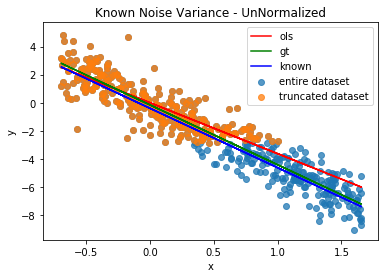

mse loss: 0.02902061492204666


In [130]:
if X.size(1) == 1:
    ax = plt.subplot(1, 1, 1)
    plt.scatter(X_norm_centered, noised_centered, label='entire dataset', alpha=.75)
    plt.scatter(x_trunc_norm_centered, y_trunc_centered, label='truncated dataset', alpha=.75)
    plt.plot(X_norm_centered, trunc_ols.predict(X_norm_centered), color='r', label='ols')
    plt.plot(X_norm_centered, gt_ols.predict(X_norm_centered), color='green', label='gt')
    plt.plot(X_norm_centered, known_trunc_reg.predict(X_norm_centered), label='known', color='blue')
    plt.legend()
    plt.title("Known Noise Variance - UnNormalized")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.show()
loss = mse_loss(known_, gt_)
print(f'mse loss: {loss}')

In [313]:
store.close()

In [314]:
reader = CollectionReader('/Users/patroklos/Desktop/exp/trunc_reg_debug_')
logs = reader.df('logs')
reader.close()
logs.head()

100%|██████████| 1/1 [00:00<00:00, 44.03it/s]


,trial,epoch,train_loss,train_prec1,train_prec5,val_loss,val_prec1,val_prec5,exp_id
0,0,1,0.016878,0.0,0.0,-0.008234,0.0,0.0,fd15e823-3085-46c0-9c67-85e2eab829b2
1,0,2,0.008836,0.0,0.0,-0.010390,0.0,0.0,fd15e823-3085-46c0-9c67-85e2eab829b2
2,0,3,0.009389,0.0,0.0,-0.014683,0.0,0.0,fd15e823-3085-46c0-9c67-85e2eab829b2
3,0,4,0.003558,0.0,0.0,-0.026249,0.0,0.0,fd15e823-3085-46c0-9c67-85e2eab829b2
4,0,5,0.003028,0.0,0.0,-0.020118,0.0,0.0,fd15e823-3085-46c0-9c67-85e2eab829b2


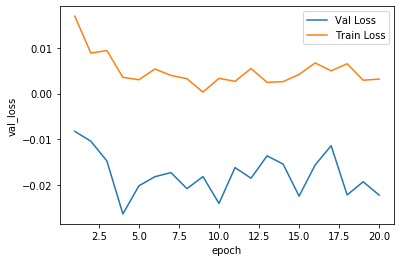

In [315]:
sns.lineplot(data=logs, x='epoch', y='val_loss', label='Val Loss')
sns.lineplot(data=logs, x='epoch', y='train_loss', label='Train Loss')

Truncated Regression with Unknown Noise Variance

In [142]:
y_trunc_emp_scale = y_trunc_centered / ch.sqrt(emp_noise_var)
phi_emp_scale = oracle.Left_Regression((phi.left - y_trunc_mu) / ch.sqrt(emp_noise_var))
train_kwargs = Parameters({
    'phi': phi_emp_scale, 
    'alpha': alpha, 
    'epochs': 10, 
    'trials': 3, 
    'batch_size': 10,
    'lr': 1e-1, 
    'var_lr': 1e-2, 
#     'step_lr_gamma': 1.0,
    'momentum': .5,
    'verbose': True,
    'fit_intercept': args.fit_intercept,
})
unknown_trunc_reg = TruncatedLinearRegression(train_kwargs)
unknown_trunc_reg.fit(x_trunc_norm_centered, y_trunc_emp_scale)

Train Epoch:3 | Loss 0.0572 | Prec1: 0.000 | Prec5: 0.000 | Reg term: 0.0 ||:   0%|          | 0/24 [00:00<?, ?it/s] 

trial: 1


Train Epoch:3 | Loss 0.0266 | Prec1: 0.000 | Prec5: 0.000 | Reg term: 0.0 ||:   0%|          | 0/24 [00:00<?, ?it/s]  

trial: 2


Train Epoch:3 | Loss 0.0383 | Prec1: 0.000 | Prec5: 0.000 | Reg term: 0.0 ||:   0%|          | 0/24 [00:00<?, ?it/s]  

trial: 3


In [143]:
w = unknown_trunc_reg.coef_*ch.sqrt(emp_noise_var)
w0 = unknown_trunc_reg.intercept_ * ch.sqrt(emp_noise_var)
unknown_ = ch.cat([w.flatten(), w0])

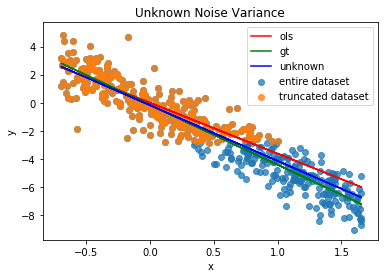

mse loss: 0.04421595484018326


In [145]:
if X.size(1) == 1:
    ax = plt.subplot(1, 1, 1)
    plt.scatter(X_norm_centered, noised_centered, label='entire dataset', alpha=.75)
    plt.scatter(x_trunc_norm_centered, y_trunc_centered, label='truncated dataset', alpha=.75)
    plt.plot(X_norm_centered, trunc_ols.predict(X_norm_centered), label='ols', color='red')
    plt.plot(X_norm_centered, gt_ols.predict(X_norm_centered), color='g', label='gt')
    plt.plot(X_norm_centered, unknown_trunc_reg.predict(X_norm_centered) * ch.sqrt(emp_noise_var), color='blue', label='unknown')
    plt.legend()
    ax.set_title("Unknown Noise Variance")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.show()
loss = mse_loss(unknown_, gt_)
print(f'mse loss: {loss}')

# Generate Ground-Truth and Run Experiment

In [47]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 10, 1
# distribution for generating feature vectors
W = Uniform(w_lower, w_upper)
dist = Uniform(-5, 5)
phi = oracle.Left_Regression(0.0)
    
    
def gen_ground_truth(): 
    # generate ground truth
    gt = ch.nn.Linear(in_features=d, out_features=k)
    gt.weight = ch.nn.Parameter(W.sample(ch.Size([k, d])))
    gt.bias = ch.nn.Parameter(W.sample(ch.Size([1, 1]))) if args.bias else None

    # create base classifier
    with ch.no_grad():
        # generate data
        X = dist.sample(ch.Size([args.samples, d])) if isinstance(dist, Uniform) else dist.sample(ch.Size([args.samples]))
        y = gt(X)
        
    return X, y

In [56]:
# create store and add table
store = Store(args.out_dir + args.exp)
store.add_table(args.table_name, { 
    'ols_r2': float,
    'ols_param_mse': float,
    'ols_var_l1': float,
    'known_emp_r2': float,
    'known_emp_param_mse': float,
    'known_emp_time': int,
    'known_r2': float,
    'known_param_mse': float,
    'known_time': int,
    'unknown_r2': float, 
    'unknown_param_mse': float,
    'unknown_var_l1': float,
    'unknown_time': int,
    'trunc_reg_r2': float,
    'trunc_reg_param_mse': float, 
    'trunc_reg_var_mse': float,
    'trunc_reg_time': int,
    'alpha': float, 
    'num_samples': int,
    'noise_var': float, 
})


# store.add_table('poor_results', { 
#     'train_nll': float, 
#     'val_nll': float, 
#     'converge': bool, 
#     'noise_var': int,
# })

large_grad = 0
large_mse = 0

phi = oracle.Left_Regression(ch.zeros(1))

for i in range(args.trials):
    # generate ground truth
    X, y = gen_ground_truth()
    
    for noise_var in range(1, args.var + 1): 
        noise_var = Tensor([noise_var])[None,...]
        # add noise to ground-truth pedictions
        noised = y + ch.sqrt(noise_var) * ch.randn(X.size(0), 1)
        # truncate based off of the standardized data
        indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = noised[indices], X[indices]
        alpha = y_trunc.size(0) / args.samples
        # mean for dependent variable
        y_trunc_mu = y_trunc.mean(0)
        
        # normalize input features
        l_inf = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
        beta = l_inf * (x_trunc.size(1) ** .5)

        X /= beta
        x_trunc /= beta
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = (y_trunc - ols.predict(x_trunc)).var(0)
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[args.table_name].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - noise_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
                
        """
        Run dataset on truncated regression with known variance, while 
        assuming that the empirical noise variance is the underlying noise 
        variance of our linear regression. This means that we want to standardize 
        our dependent variable by the empirical noise variance. 
        """
        # variance of the residuals
        # standardize y trunc by the empirical noise variance
        emp_stand_y_trunc = (y_trunc - y_trunc_mu) / ch.sqrt(ols_var)
        # standardize noised by the empirical noise variance
        emp_stand_noised = noised / ch.sqrt(ols_var)
        
        emp_stand_phi = oracle.Left_Regression((phi.left - y_trunc_mu) / ch.sqrt(ols_var))
        st = datetime.datetime.now()    
        train_kwargs = Parameters({
            'phi': emp_stand_phi, 
            'alpha': alpha, 
            'noise_var': float(emp_noise_var), 
            'epochs': 5,
            'momentum': .25,
            'verbose': True,
            'num_trials': 1,
        })    
        known_emp_trunc_reg = TruncatedLinearRegression(train_kwargs)
        known_emp_trunc_reg.fit(x_trunc, emp_stand_y_trunc)    
        total_time = int((datetime.datetime.now() - st).total_seconds())
        w, w0 = (known_emp_trunc_reg.coef_ * ch.sqrt(emp_noise_var)), known_emp_trunc_reg.intercept_[..., None] * ch.sqrt(emp_noise_var) + y_trunc_mu
        known_emp_params = ch.cat([w, w0], dim=1).flatten()

        # known emp results
        store[args.table_name].update_row({
            'known_emp_r2': r2_score(noised.flatten(), X@w.T + w0), 
            'known_emp_param_mse': mse_loss(known_emp_params, gt_params),
            'known_emp_time': total_time, 
        })

        """
        Run dataset on truncated regression with known variance. This means that we want to standardize 
        our dependent variable by the true noise variance. 
        """
        # standardize y trunc by actual noise variance
        stand_y_trunc = (y_trunc - y_trunc_mu) / ch.sqrt(noise_var)
        # standardize noised by actual noise variance
        stand_phi = oracle.Left_Regression((phi.left - y_trunc_mu) / ch.sqrt(noise_var))

        st = datetime.datetime.now()    
        train_kwargs = Parameters({
            'phi': stand_phi, 
            'alpha': alpha, 
            'noise_var': 1.0, 
            'epochs': 5,
            'momentum': .25,
            'verbose': True,
            'num_trials': 1,
        })    
        known_trunc_reg = TruncatedLinearRegression(train_kwargs)
        known_trunc_reg.fit(x_trunc, stand_y_trunc)    
        total_time = int((datetime.datetime.now() - st).total_seconds())
        w, w0 = (known_trunc_reg.coef_ * ch.sqrt(noise_var)), known_trunc_reg.intercept_[..., None] * ch.sqrt(noise_var) + y_trunc_mu
        known_params = ch.cat([w, w0], dim=1).flatten()
        
        # known results
        store[args.table_name].update_row({
            'known_r2': r2_score(noised.flatten(), X@w.T + w0), 
            'known_param_mse': mse_loss(gt_params, known_params),
            'known_time': total_time, 
        })

        st = datetime.datetime.now()   
        train_kwargs = Parameters({
            'phi': emp_stand_phi, 
            'alpha': alpha, 
            'epochs': 5,
            'momentum': .25,
            'verbose': True,
            'num_trials': 1,
        })     
        unknown_trunc_reg = TruncatedLinearRegression(train_kwargs)
        unknown_trunc_reg.fit(x_trunc, emp_stand_y_trunc)
        total_time = int((datetime.datetime.now() - st).total_seconds())

        unknown_var = unknown_trunc_reg.variance * ols_var
        w, w0 = (unknown_trunc_reg.coef_ * ch.sqrt(ols_var)), (unknown_trunc_reg.intercept_ * ch.sqrt(ols_var) + y_trunc_mu)[...,None]
        unknown_params = ch.cat([w, w0], dim=1).flatten()
        

        
        unknown_param_mse = mse_loss(gt_params, unknown_params)
        if unknown_param_mse >= 2.0: 
            large_mse += 1
            for x, y_ in unknown_trunc_reg.val_loader: 
                val_nll = unknown_trunc_reg.trunc_reg.calc_nll(x, y_)
                grad = unknown_trunc_reg.trunc_reg.calc_grad(x, y_)
                converge = (grad <= args.tol).all()

            for x, y_ in unknown_trunc_reg.train_loader: 
                train_nll = unknown_trunc_reg.trunc_reg.calc_nll(x, y_)
                break
                
        
            # store['poor_results'].update_row({
            #     'train_nll': train_nll, 
            #     'val_nll': val_nll, 
            #     'converge': converge,
            #     'noise_var': noise_var
            # })
            
            # store['poor_results'].flush_row()
                
        # known emp results
        store[args.table_name].update_row({
            'unknown_r2': r2_score(noised.flatten(), X@w.T + w0), 
            'unknown_param_mse': mse_loss(gt_params, unknown_params),
            'unknown_var_l1': float(ch.abs(unknown_var - noise_var)),
            'unknown_time': total_time, 
        })
            
            
        # spawn subprocess to run truncreg experiment
        concat = ch.cat([x_trunc, y_trunc], dim=1).numpy()
        """
        DATA FORMAT:
            -First n-1 columns are independent variables
            -nth column is dependent variable
        """
        concat_df = pd.DataFrame(concat)
        concat_df.to_csv(args.out_dir + '/' + TMP_FILE) # save data to csv
        """
        Arguments
        - c - truncation point (float)
        - dir - left or right -> type of truncation (str)
        """
        cmd = [COMMAND, PATH2SCRIPT] + [str(0), str(d), 'left', args.out_dir]

        # check_output will run the command and store the result
        st = datetime.datetime.now()
        result = subprocess.check_output(cmd, universal_newlines=True)
        total_time = int((datetime.datetime.now() - st).total_seconds())
        trunc_res = Tensor(pd.read_csv(args.out_dir + '/' + RESULT_FILE)['x'].to_numpy())
        trunc_reg_params = ch.cat([trunc_res[1:-1].flatten(), trunc_res[0][None,...]])

        trunc_reg_pred = X@trunc_reg_params[:-1] + trunc_reg_params[-1]
        
        # truncreg results
        store[args.table_name].update_row({
            'trunc_reg_r2': r2_score(noised.flatten(), trunc_reg_pred.flatten()), 
            'trunc_reg_param_mse': mse_loss(trunc_reg_params, gt_params),
            'trunc_reg_var_mse': float(ch.abs(trunc_res[-1].pow(2)[None,...] - noise_var)),
            'trunc_reg_time': total_time, 
        })
        
        # add additional exp data to store
        store[args.table_name].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_var': noise_var, 
        })

        # append row to table
        store[args.table_name].flush_row()
        
        IPython.display.clear_output()

store.close()    

Logging in: /content/drive/MyDrive/Results/trunc_reg/rervival/80032631-b1c7-40cb-8ab8-ad22cc83f5cc


CalledProcessError: ignored

In [ ]:
reader = CollectionReader(args.out_dir + '/' + args.exp)
logs = reader.df(args.table_name)
# poor_results = reader.df('poor_results')
reader.close()
logs.head(10)

100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


,ols_r2,ols_param_mse,ols_var_l1,known_r2,known_param_mse,known_time,unknown_r2,unknown_param_mse,unknown_var_l1,unknown_time,trunc_reg_r2,trunc_reg_param_mse,trunc_reg_var_mse,trunc_reg_time,alpha,num_samples,noise_var,exp_id
0,0.919864,0.432705,0.061598,0.941135,0.038272,16,0.939486,0.067332,0.053015,1,0.940754,0.034685,0.032654,0,0.502667,754,1.0,837f7870-dfd9-4cef-be28-5c61cc63949f
1,0.813471,1.758263,0.334296,0.879476,0.484447,15,0.895083,0.128968,0.048412,1,0.893422,0.116251,0.043236,0,0.494000,741,2.0,837f7870-dfd9-4cef-be28-5c61cc63949f
2,0.735197,2.638096,0.608368,0.845774,0.381254,16,0.834389,0.564952,0.320493,1,0.849624,0.165917,0.109880,0,0.508667,763,3.0,837f7870-dfd9-4cef-be28-5c61cc63949f
3,0.663425,2.853571,0.854965,0.799452,0.307403,15,0.778606,0.546359,0.271009,1,0.798979,0.252207,0.257234,0,0.484000,726,4.0,837f7870-dfd9-4cef-be28-5c61cc63949f
4,0.605695,3.763897,1.438328,0.772314,0.468740,16,0.780413,0.213085,0.011284,1,0.782388,0.162499,0.174946,0,0.490667,736,5.0,837f7870-dfd9-4cef-be28-5c61cc63949f
5,0.456628,5.348772,1.851150,0.694088,1.069650,20,0.720098,0.241409,0.101773,1,0.722143,0.190485,0.197092,0,0.489333,734,6.0,837f7870-dfd9-4cef-be28-5c61cc63949f
6,0.381663,7.899115,2.622770,0.637642,2.542969,18,0.684961,1.184335,0.894857,1,0.678221,1.057704,0.883207,0,0.491333,737,7.0,837f7870-dfd9-4cef-be28-5c61cc63949f
7,0.319984,8.750479,3.184480,0.640802,1.813212,18,0.664154,0.732471,0.700975,1,0.666126,0.653326,0.467048,0,0.511333,767,8.0,837f7870-dfd9-4cef-be28-5c61cc63949f
8,0.244285,8.424655,3.947756,0.596598,2.050194,19,0.583841,1.498760,1.503243,1,0.620563,0.952123,0.989464,0,0.486000,729,9.0,837f7870-dfd9-4cef-be28-5c61cc63949f
9,0.250309,8.623458,3.869784,0.597356,1.375096,18,0.603521,0.752158,0.992073,1,0.618344,0.517917,0.220717,0,0.486667,730,10.0,837f7870-dfd9-4cef-be28-5c61cc63949f


In [ ]:
logs['unknown_epsilon'] = logs['unknown_param_mse'] + logs['unknown_var_l1']
logs['trunc_reg_epsilon'] = logs['trunc_reg_param_mse'] + logs['trunc_reg_var_mse']
logs['ols_epsilon'] = logs['ols_param_mse'] + logs['ols_var_l1']

In [ ]:
logs['unknown_param_mse'] = logs['unknown_param_mse'] **(1/2)
logs['known_param_mse'] = logs['known_param_mse'] **(1/2)
logs['ols_param_mse'] = logs['ols_param_mse'] **(1/2)
# known_emp_logs['known_emp_param_mse'] = known_emp_logs['known_emp_param_mse'] **(1/2)
logs['trunc_reg_param_mse'] = logs['trunc_reg_param_mse'] **(1/2)

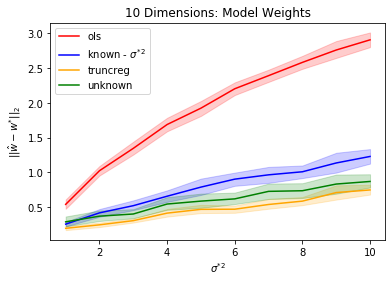

Text(0.5, 1.0, '10 Dimensions : Variance')

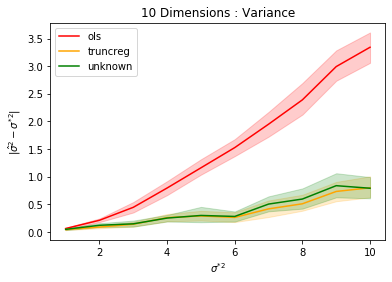

In [ ]:
sns.lineplot(data=logs, x='noise_var', y='ols_param_mse', label='ols', color='r')
# sns.lineplot(data=known_emp_logs, x='noise_var', y='known_emp_param_mse', color='purple', label='known - $\sigma_{0}^{2}$')
sns.lineplot(data=logs, x='noise_var', y='known_param_mse', label='known - $\sigma^{*2}$', color='blue')
sns.lineplot(data=logs, x='noise_var', y='trunc_reg_param_mse', label='truncreg', color='orange')
ax = sns.lineplot(data=logs, x='noise_var', y='unknown_param_mse', label='unknown', color='green')

ax.set(xlabel='$\sigma^{*2}$', ylabel='$||\hat w - w^{*}||_{2}$')
ax.set_title(args.exp + " : Model Weights")
ax.set_title("10 Dimensions: Model Weights")

plt.show()

sns.lineplot(data=logs, x='noise_var', y='ols_var_l1', label='ols', color='red')
sns.lineplot(data=logs, x='noise_var', y='trunc_reg_var_mse', label='truncreg', color='orange')
ax = sns.lineplot(data=logs, x='noise_var', y='unknown_var_l1', label='unknown', color='green')
ax.set(xlabel='$\sigma^{*2}$', ylabel='$|\hat \sigma^{2} - \sigma^{*2}|$')
ax.set_title("10 Dimensions : Variance")

In [ ]:
alpha = 5.0 
lower_p = (alpha / 2.0) / 100
upper_p = ((100 - alpha) + (alpha / 2.0)) / 100


trunc_reg_w_scores, trunc_reg_var_scores = [], [] 
unknown_w_score, unknown_var_scores = [], []
known_scores = []
ols_scores = {}
for var in range(1, args.var + 1):
    trunc_reg_w_scores, trunc_reg_var_scores = [], [] 
    unknown_w_score, unknown_var_scores = [], []
    known_scores = []
    ols_w_scores, ols_var_scores = [], []
    temp_logs = logs[logs.noise_var == var]

    for i in range(100):
#         # bootstrap sample
#         indices = randint(0, args.trials, args.trials)
        ols_w_scores.append(temp_logs.ols_param_mse.reset_index().loc[list(ch.randint(args.trials, (args.trials,)))].ols_param_mse.mean())
        ols_var_scores.append(temp_logs.ols_var_l1.reset_index().loc[list(ch.randint(args.trials, (args.trials,)))].ols_var_l1.mean())
        
        
#         trunc_reg_w_scores.append()
#         break
    ols_w_scores, ols_var_scores = Tensor(ols_w_scores), Tensor(ols_var_scores)
    w_median = ols_w_scores.median()
    var_median = ols_var_scores.median()
    # calculate 95% confidence interval (100 - alpha)
    w_lower, w_upper = ch.quantile(ols_w_scores, lower_p), ch.quantile(ols_w_scores, upper_p)
    var_lower, var_upper = ch.quantile(ols_var_scores, lower_p), ch.quantile(ols_var_scores, upper_p)
    ols_scores['w_' + str(var)] = (float(w_median), float(w_lower), float(w_upper))
    ols_scores['var_' + str(var)] = (float(var_median), float(var_lower), float(var_upper))

In [ ]:
temp_logs.ols_param_mse.reset_index().loc[list(ch.randint(args.trials, (args.trials,)))].ols_param_mse

6     3.030272
6     3.030272
19    3.223487
15    2.931073
2     3.547897
9     3.126174
16    3.001810
0     2.873226
4     2.735724
7     3.405046
2     3.547897
5     2.645933
2     3.547897
0     2.873226
9     3.126174
11    3.054120
16    3.001810
1     3.001408
12    2.722246
0     2.873226
Name: ols_param_mse, dtype: float64

In [ ]:
ols_scores

{'w_1': (0.600812554359436, 0.5397992134094238, 0.6643595099449158),
 'var_1': (0.08511735498905182, 0.059293828904628754, 0.1030203253030777),
 'w_2': (1.0421823263168335, 0.9507401585578918, 1.1385873556137085),
 'var_2': (0.23780572414398193, 0.187019482254982, 0.2787726819515228),
 'w_3': (1.4848092794418335, 1.3937994241714478, 1.5721241235733032),
 'var_3': (0.5787283182144165, 0.4987471103668213, 0.6642507910728455),
 'w_4': (1.7780349254608154, 1.6675844192504883, 1.8767249584197998),
 'var_4': (0.8503002524375916, 0.7792227268218994, 0.9504703283309937),
 'w_5': (2.016340494155884, 1.9012539386749268, 2.111964225769043),
 'var_5': (1.2625733613967896, 1.1418821811676025, 1.365757703781128),
 'w_6': (2.2523915767669678, 2.1477010250091553, 2.405884027481079),
 'var_6': (1.567497730255127, 1.4404025077819824, 1.746000051498413),
 'w_7': (2.4736948013305664, 2.380859136581421, 2.638007164001465),
 'var_7': (2.012190580368042, 1.8744463920593262, 2.1975018978118896),
 'w_8': (2.66

In [ ]:
alpha = 5.0 
ols_ = {}
for key in ols_scores.keys():
    median = ols_scores[key].mean()
    # calculate 95% confidence interval (100 - alpha)
    lower_p = alpha / 2.0
    lower = ch.quantile(ols_scores[key], lower_p / 100)
    upper_p = (100 - alpha) + (alpha / 2.0)
    upper = ch.quantile(ols_scores[key], upper_p / 100)

In [ ]:
median, lower, upper

(tensor(2.6757), tensor(2.5450), tensor(2.8050))

tensor(2.8050)

In [ ]:
import torch.linalg as LA
l_inf = LA.norm(X, dim=-1, ord=float('inf')).max()
beta = l_inf * X.size(1) ** (.5)

In [ ]:
x_norm = X / beta

In [ ]:
gt_norm = LinearRegression()
gt_norm.fit(x_norm, y)

LinearRegression()

In [ ]:
norm_w = np.concatenate([gt_norm.coef_, gt_norm.intercept_.reshape(-1, 1)], axis=1)

In [ ]:
w_ = np.concatenate([gt_ols.coef_, gt_ols.intercept_.reshape(-1, 1)], axis=1)

In [ ]:
norm_w / w_

array([[15.91523  , 15.874461 , 21.831177 , 15.561473 , 15.849096 ,
        15.670087 , 15.684167 , 15.925425 , 15.788613 , 15.7659235,
         1.0026407]], dtype=float32)

In [ ]:
beta

tensor(15.8109)

In [ ]:
poor_results_schema = { 
    'train_nll': float, 
    'val_nll': float, 
    'converge': bool, 
    'noise_var': int,
}

(tensor(2.8282), tensor([0.0923]))

In [ ]:
gt_unknown_params[:,-1]

tensor([0.0923])

In [ ]:
gt_params

tensor([-5.3711, -3.9572,  0.3237])

In [ ]:
known_params

tensor([-5.9933, -4.8433, -0.2351])

In [ ]:
unknown_params

tensor([-33.6909, -33.2362, -30.2377])

In [ ]:
ols_params

tensor([-2.7725, -2.2341,  2.7319])

In [ ]:
mse_loss(gt_params, known_params)

tensor(9.8939)

In [ ]:
mse_loss(gt_params, ols_params)

tensor(10.9179)

In [ ]:
mse_loss(gt_params, unknown_params)

tensor(4.6358)

In [ ]:
mse_loss(gt_params, trunc_reg_params)

tensor(0.6809)

In [ ]:
unknown_var

tensor([[7.6996]])

In [ ]:
trunc_res[-1].pow(2)[None,...]

tensor([10.0126])

In [ ]:
noise_var

tensor([[10.]])

In [ ]:
my_list = ch.randn(100000, 1)

In [ ]:
!tqdm --version

4.36.1


In [ ]:
noised = y + ch.sqrt(noise_var) * ch.randn(X.size(0), 1)


RuntimeError: The size of tensor a (50) must match the size of tensor b (1500) at non-singleton dimension 0

In [ ]:
stand_y_trunc.var()

tensor(1.3272)

In [ ]:
X.size(0)

1500

In [ ]:
noise_var

tensor([[10.]])

In [ ]:
x_, y_ = gen_ground_truth()

In [ ]:
x_.size(), y_.size()

(torch.Size([1500, 2]), torch.Size([1500, 1]))

In [ ]:
y.size()

torch.Size([50, 1])

In [ ]:
noise_var, stand_y_trunc.var()

(tensor([[10.]]), tensor(1.3272))

In [ ]:
known_params

tensor([  3.8552,   3.9957,  11.0500,   2.0983,   3.5950,   5.7007, -10.0353,
          7.4186,  -0.3144,  10.8848,   1.0893])

In [ ]:
gt_params

tensor([  5.3274,   5.9516,  15.2384,   2.6309,   4.6678,   7.9395, -14.1709,
          9.6652,  -0.3480,  14.1360,  -0.8966])

In [85]:
%%R
install.packages('truncreg')

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/truncreg_0.2-5.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 6699 bytes

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to conso

In [113]:
%load_ext rpy2.ipython

X_ = x_trunc.numpy()
%R -i X_

y_ = y_trunc.numpy()
%R -i y_

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [129]:
%%R
library(truncreg)
X <- as.matrix(X_)
y <- as.matrix(y_)
df <- data.frame(X=X, y=y)
# truncated regression procedure
trunc_reg <- truncreg(df$y ~ X, data=df, point=0, direction='left', scaled=TRUE)
# return model coefficients
# coef_df <- coef(trunc_reg)

R[write to console]: Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In if (class(X) == "matrix") formula.type <- FALSE else formula.type <- TRUE :
R[write to console]: 
 
R[write to console]:  the condition has length > 1 and only the first element will be used




Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent


RInterpreterError: ignored

In [130]:
%%R
print(colnames(df))
dimnames(df)

 [1] "X.1"  "X.2"  "X.3"  "X.4"  "X.5"  "X.6"  "X.7"  "X.8"  "X.9"  "X.10"
[11] "y"   
[[1]]
  [1] "1"   "2"   "3"   "4"   "5"   "6"   "7"   "8"   "9"   "10"  "11"  "12" 
 [13] "13"  "14"  "15"  "16"  "17"  "18"  "19"  "20"  "21"  "22"  "23"  "24" 
 [25] "25"  "26"  "27"  "28"  "29"  "30"  "31"  "32"  "33"  "34"  "35"  "36" 
 [37] "37"  "38"  "39"  "40"  "41"  "42"  "43"  "44"  "45"  "46"  "47"  "48" 
 [49] "49"  "50"  "51"  "52"  "53"  "54"  "55"  "56"  "57"  "58"  "59"  "60" 
 [61] "61"  "62"  "63"  "64"  "65"  "66"  "67"  "68"  "69"  "70"  "71"  "72" 
 [73] "73"  "74"  "75"  "76"  "77"  "78"  "79"  "80"  "81"  "82"  "83"  "84" 
 [85] "85"  "86"  "87"  "88"  "89"  "90"  "91"  "92"  "93"  "94"  "95"  "96" 
 [97] "97"  "98"  "99"  "100" "101" "102" "103" "104" "105" "106" "107" "108"
[109] "109" "110" "111" "112" "113" "114" "115" "116" "117" "118" "119" "120"
[121] "121" "122" "123" "124" "125" "126" "127" "128" "129" "130" "131" "132"
[133] "133" "134" "135" "136" "137" "138" "139" "

In [79]:
x_trunc.size(), y_trunc.size()

(torch.Size([469, 10]), torch.Size([469, 1]))

In [8]:
from torch.nn import MSELoss

NameError: name 'ch' is not defined

(tensor([[76.9764],
         [-1.7127]]),)

output: (tensor([[ 3.4020e-04],
        [-2.8871e-05],
        [ 5.4262e-04],
        ...,
        [ 9.9043e-04],
        [-7.9562e-04],
        [-2.7680e-04]]), tensor([[-2.6022e-04],
        [-4.6293e-05],
        [-3.7677e-04],
        ...,
        [-6.4016e-04],
        [ 4.0875e-04],
        [ 1.0456e-04]]))


(tensor([[38.4875],
         [-0.8564]]),)

In [45]:
pred.size()

torch.Size([10000, 1])

In [68]:

X_ = ch.cat([X, ch.ones(X.size(0), 1)], axis=1)
# calculate original ols 
gt = LinearRegression(fit_intercept=False)
gt.fit(X_.numpy(), y)

weight = ch.nn.Parameter(ch.from_numpy(gt.coef_).T)

opt = ch.optim.SGD([weight], lr=1e-2)


loader = ch.utils.data.DataLoader(ch.utils.data.TensorDataset(X_, y), batch_size=100, shuffle=True)

# iterate over epochs
for i in range(10):

    for batch in loader: 
        opt.zero_grad()
        x_, y_ = batch
        pred = x_@weight
        
        
        loss = TruncatedMSE.apply(pred, y_, oracle.Identity(), noise_var)
        loss.backward()
        opt.step()
        
        print('grad: {}'.format(weight.grad))
        

grad: tensor([[-0.0600],
        [ 0.0216]])
grad: tensor([[0.1763],
        [0.0030]])
grad: tensor([[-0.3470],
        [-0.0044]])
grad: tensor([[-0.1934],
        [ 0.0178]])
grad: tensor([[ 0.0703],
        [-0.0213]])
grad: tensor([[0.0590],
        [0.0486]])
grad: tensor([[0.2103],
        [0.0508]])
grad: tensor([[ 0.1401],
        [-0.0220]])
grad: tensor([[0.3397],
        [0.0580]])
grad: tensor([[-0.0349],
        [-0.0367]])
grad: tensor([[-0.0007],
        [-0.0107]])
grad: tensor([[-0.2366],
        [ 0.0240]])
grad: tensor([[ 0.3621],
        [-0.0125]])
grad: tensor([[-0.0965],
        [-0.0354]])
grad: tensor([[0.0574],
        [0.0212]])
grad: tensor([[-0.0403],
        [-0.0349]])
grad: tensor([[-0.1275],
        [-0.0002]])
grad: tensor([[-0.2531],
        [ 0.0585]])
grad: tensor([[-0.1811],
        [-0.0194]])
grad: tensor([[ 0.0299],
        [-0.0166]])
grad: tensor([[-0.1178],
        [ 0.0233]])
grad: tensor([[0.2608],
        [0.0028]])
grad: tensor([[0.3649]

grad: tensor([[-0.0589],
        [ 0.0026]])
grad: tensor([[0.3435],
        [0.0173]])
grad: tensor([[ 0.0034],
        [-0.0115]])
grad: tensor([[-0.1892],
        [-0.0159]])
grad: tensor([[0.1923],
        [0.0060]])
grad: tensor([[-0.0961],
        [ 0.0785]])
grad: tensor([[ 0.2790],
        [-0.0053]])
grad: tensor([[-0.1334],
        [ 0.0145]])
grad: tensor([[-0.2584],
        [-0.0121]])
grad: tensor([[ 0.0974],
        [-0.0294]])
grad: tensor([[-0.2706],
        [ 0.0076]])
grad: tensor([[-0.2660],
        [-0.0195]])
grad: tensor([[0.1236],
        [0.0450]])
grad: tensor([[0.0422],
        [0.0543]])
grad: tensor([[-0.1698],
        [ 0.0069]])
grad: tensor([[-0.0656],
        [-0.0360]])
grad: tensor([[0.0158],
        [0.0235]])
grad: tensor([[ 0.0875],
        [-0.0161]])
grad: tensor([[ 0.0391],
        [-0.0602]])
grad: tensor([[-0.2127],
        [-0.0079]])
grad: tensor([[-0.0085],
        [-0.0200]])
grad: tensor([[0.1859],
        [0.0004]])
grad: tensor([[0.1358]

grad: tensor([[0.0511],
        [0.0267]])
grad: tensor([[ 0.3372],
        [-0.0322]])
grad: tensor([[-0.0139],
        [ 0.0156]])
grad: tensor([[-0.2936],
        [-0.0171]])
grad: tensor([[ 0.2811],
        [-0.0214]])
grad: tensor([[-0.1652],
        [ 0.0359]])
grad: tensor([[-0.2174],
        [ 0.0308]])
grad: tensor([[-0.0238],
        [ 0.0278]])
grad: tensor([[-0.0054],
        [ 0.0509]])
grad: tensor([[0.2915],
        [0.0265]])
grad: tensor([[-0.0750],
        [ 0.0007]])
grad: tensor([[ 0.1500],
        [-0.0399]])
grad: tensor([[-0.0786],
        [-0.0334]])
grad: tensor([[-0.2351],
        [-0.0006]])
grad: tensor([[0.0394],
        [0.0438]])
grad: tensor([[0.2173],
        [0.0340]])
grad: tensor([[-0.2215],
        [ 0.0243]])
grad: tensor([[ 0.1863],
        [-0.0382]])
grad: tensor([[ 0.0025],
        [-0.0189]])
grad: tensor([[0.0205],
        [0.0161]])
grad: tensor([[ 0.2719],
        [-0.0063]])
grad: tensor([[-0.4548],
        [ 0.0167]])
grad: tensor([[-0.22

grad: tensor([[-0.2947],
        [-0.0376]])
grad: tensor([[ 0.1564],
        [-0.0149]])
grad: tensor([[-0.4117],
        [-0.0341]])
grad: tensor([[ 0.4194],
        [-0.0319]])
grad: tensor([[-0.2364],
        [-0.0161]])
grad: tensor([[-0.0090],
        [ 0.0196]])
grad: tensor([[-0.3012],
        [ 0.0090]])
grad: tensor([[ 0.1964],
        [-0.0070]])
grad: tensor([[0.0094],
        [0.0373]])


Parameter containing:
tensor([[0.3696],
        [0.2583]], requires_grad=True)

In [58]:
gt.coef_

array([[59653.242, 10913.049]], dtype=float32)